In [1]:
import pygad.kerasga
import pygad
from pygad.kerasga import KerasGA
import numpy
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import tensorflow 
import time
from IPython.display import display, clear_output, HTML
import os
import subprocess

In [2]:
MEMORY_SIZE = 5 # can remember last memory_size rounds
NUM_ROUNDS = MEMORY_SIZE
NUM_SOLUTION = 50 # number of people in the network
NUM_MAX_NUMBER = 100

NUM_GENERATIONS = 200 # Number of generations.
NUM_PARENTS_MATING = 10 # Number of solutions to be selected as parents in the mating pool.

NUM_ACTIVATION_THRESHOLD = 0.6

fit_history = []

def get_number_from_output(out):
    b = ""
    for o in out:
        if o > NUM_ACTIVATION_THRESHOLD:
            b += "1"
        else:
            b += "0"
    return int(b, 2)


def bits_needed(number):
    return number.bit_length()

# memory array holds memory of all instances
g_memory_array = numpy.zeros(shape=(MEMORY_SIZE, NUM_MAX_NUMBER), dtype=int) + NUM_SOLUTION
g_buffer_memory_array = numpy.zeros(shape=(MEMORY_SIZE, NUM_MAX_NUMBER), dtype=int) + NUM_SOLUTION

In [3]:
model = tensorflow.keras.Sequential([
    tensorflow.keras.Input(shape=(g_memory_array.shape[0], g_memory_array.shape[1], 1)),
    tensorflow.keras.layers.Conv2D(filters=2, kernel_size=3, strides=2, activation='relu'),
    tensorflow.keras.layers.MaxPool2D(),
    tensorflow.keras.layers.Flatten(),
    tensorflow.keras.layers.Dense(10, activation="relu"),
    tensorflow.keras.layers.Dense(10, activation="sigmoid"),
    tensorflow.keras.layers.Dense(bits_needed(NUM_MAX_NUMBER), activation="sigmoid")
])
model.summary()
keras_ga = KerasGA(model=model, num_solutions=NUM_SOLUTION)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 2, 49, 2)       │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 1, 24, 2)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           490 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │            77 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 697 (2.72 KB)

 Trainable params: 697 (2.72 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
round_predictions = numpy.zeros(shape=(NUM_ROUNDS, NUM_SOLUTION), dtype=int)
all_predicionts = numpy.zeros(shape=(NUM_GENERATIONS + 1, NUM_ROUNDS, NUM_SOLUTION), dtype=int)
t_array = []

AMOUNT_DIGITS = len(str(abs(NUM_GENERATIONS * NUM_ROUNDS)))
display_handle = display(HTML("Starting..."), display_id=True)

all_raws = []
all_means = []

def generate_loading_bar(progress, total=30):
    filled_length = int(total * progress)
    bar = '#' * filled_length + ' ' * (total - filled_length)
    return f"[{bar}] {progress * 100:.1f}%"

def do_graph(title):
    global AMOUNT_DIGITS
    
    fig, (ax, ax2) = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios':[3,1]})
    
    ax.bar(numpy.arange(len(g_memory_array[-1])), g_memory_array[-1])
    ax.axvline(numpy.mean(numpy.repeat(numpy.arange(len(g_memory_array[-1])), g_memory_array[-1])), color="r", linestyle="--")
    #plt.axis('off') 
    ax.set_title(title)
    ax.set_ylim([0, NUM_SOLUTION])
    ax.set_xlabel("All Players")
    ax.set_ylabel("Occurences")
    
    colors = ['green', 'red']
    cmap = ListedColormap(colors)
    binary_mask = numpy.transpose(numpy.array(all_raws)) > NUM_ACTIVATION_THRESHOLD
    ax2.imshow(binary_mask, cmap=cmap, interpolation='nearest', vmin=0, vmax=1)
    ax2.set_ylabel("Bits")
    ax2.set_xlabel("Players")
    plt.savefig(f"./out/img_{do_graph.graph_index:0{AMOUNT_DIGITS}}.png", bbox_inches='tight')
    
    do_graph.graph_index += 1
    
    plt.close()

do_graph.graph_index = 0

def do_the_thing(ga_instance):
    if do_the_thing.gen == ga_instance.generations_completed:
        return
    do_the_thing.gen += 1
    
    global g_memory_array, model, round_predictions, display_handle, all_raws

    g_memory_array = numpy.zeros(shape=(MEMORY_SIZE, NUM_MAX_NUMBER), dtype=int) + NUM_SOLUTION
    for round in range(NUM_ROUNDS):
        t_start = time.time()

        all_raws = []
        for i, sol in enumerate(ga_instance.population):
            raw_prediction = pygad.kerasga.predict(model, sol, g_memory_array.reshape(1, MEMORY_SIZE, NUM_MAX_NUMBER, 1)) 
            all_raws.append(raw_prediction[0])
            round_predictions[round, i] = get_number_from_output(raw_prediction[0])

        g_memory_array = numpy.append(g_memory_array, numpy.bincount(round_predictions[round], minlength=NUM_MAX_NUMBER)[:NUM_MAX_NUMBER]).reshape((MEMORY_SIZE + 1, NUM_MAX_NUMBER))[1:]
        #do_graph(f"Geneartion {ga_instance.generations_completed} Round {round}")

        t_end = time.time()
        t_array.append(t_end - t_start)
        clear_output(wait=True)
        display_handle.update(HTML(f"""Currently at <b>Generation {ga_instance.generations_completed}</b> and <b>Round {round}</b><br>
                                        Avg time for rounds {numpy.mean(t_array):.2f} s<br>
                                        ETA for remaining {NUM_ROUNDS - round} rounds: {numpy.mean(t_array) * (NUM_ROUNDS - round):.2f} s<br>
                                        ETA for all gens: {numpy.mean(t_array) * (NUM_ROUNDS * NUM_GENERATIONS - NUM_ROUNDS * (ga_instance.generations_completed - 1) - round)/60:.2f} min<br>
                                        <pre><code>{generate_loading_bar((NUM_ROUNDS * (ga_instance.generations_completed) + round)/(NUM_ROUNDS * (NUM_GENERATIONS + 1)))}</code></pre>"""))
    all_predicionts[ga_instance.generations_completed] = round_predictions
        
    

do_the_thing.gen = -1

In [5]:
#last_guesses = np.bincount(np.random.randint(0, amount_num+1, size=config.pop_size), minlength=amount_num+1)

def fitness(ga_instance, solution, sol_idx):
    if sol_idx == None:
        sol_idx = 1
    global g_buffer_memory_array, g_memory_array

    do_the_thing(ga_instance)

    return -numpy.sum(round_predictions[:,sol_idx] - numpy.mean(round_predictions, axis=1)/2)**2 


def on_gen(ga_instance):
    fit_history.append(numpy.mean(ga_instance.cal_pop_fitness()))
    

In [6]:
ga_instance = pygad.GA(num_generations=NUM_GENERATIONS,
                       num_parents_mating=NUM_PARENTS_MATING,
                       initial_population=keras_ga.population_weights,
                       mutation_type="adaptive",
                       mutation_probability=[0.2, 0.01],
                       suppress_warnings=True,
                       fitness_func=fitness,
                       on_generation=on_gen)

ga_instance.run()

FileNotFoundError: [Errno 2] No such file or directory: './out/fitness.png'

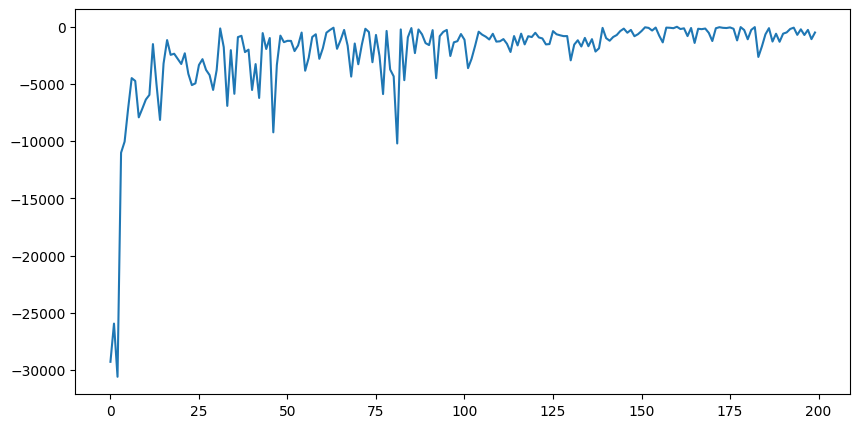

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(fit_history)), fit_history)
plt.savefig(f"./out/fitness.png", bbox_inches='tight')

In [9]:
numpy.savetxt("fitness.txt", fit_history)

In [8]:
numpy.savetxt(f"gen {NUM_GENERATIONS} round {NUM_ROUNDS} sol {NUM_SOLUTION}.txt", all_predicionts.reshape(NUM_GENERATIONS + 1, NUM_ROUNDS * NUM_SOLUTION))

# ONLY WORKS ON WINIDOWS
# Start a new shell session

p = os.path.join(os.getcwd(), "out")
process = subprocess.Popen("cmd", stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

# Send multiple commands to the same shell instance
commands = f"""
cd \"{p}\"

ffmpeg -framerate 30 -i img_%04d.png output.mp4
"""

# Send the commands to the shell
stdout, stderr = process.communicate(commands)

# Print the output and error (if any)
print("Standard Output:")
print(stdout)
print("Standard Error:")
print(stderr)


In [10]:
model.save("model.keras")
ga_instance.save("model")